In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import pandas as pd
import numpy as np
from pacmagic_deeplearning.modeling.classifiers.bayesian.train_utils import make_performance_uncertainty_plot, cross_entropy

from utils import get_weight_tensor_from_class_weights, train, plot_calibration_curve, make_precision_accuracy_plot
from utils import NN

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score

In [2]:
X_train = pd.read_csv('../../data/MIMIC/X_train_processed.csv')
y_train = pd.read_csv('../../data/MIMIC/y_train.csv')

X_test = pd.read_csv('../../data/MIMIC/X_test_processed.csv')
y_test = pd.read_csv('../../data/MIMIC/y_test.csv')

In [3]:
data = torch.from_numpy(X_train.values).float()
target = torch.from_numpy(y_train.values).float()

data_val = torch.from_numpy(X_test.values).float()
target_val = torch.from_numpy(y_test.values).float()

In [4]:
optimal_weight = y_train.mean().item()
# optimal_weight = 0.27
# optimal_weight = 0.5


In [5]:
quantiles = np.concatenate([
    np.linspace(0, optimal_weight, 5, endpoint=False),
    np.linspace(optimal_weight, 2 * optimal_weight, 6, endpoint=True)
])

In [6]:
quantiles

array([0.        , 0.01677752, 0.03355505, 0.05033257, 0.0671101 ,
       0.08388762, 0.10066514, 0.11744267, 0.13422019, 0.15099772,
       0.16777524])

In [7]:
len(quantiles)

11

In [8]:
canonical = NN(quantiles=[optimal_weight])

optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)
canonical = train(canonical, data, target, data_val,
                 target_val, optimizer, [optimal_weight])

Validation loss: 0.09, Train loss: 0.11
Validation loss: 0.07, Train loss: 0.07
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06
Validation loss: 0.06, Train loss: 0.06


In [9]:
outputs_val = torch.sigmoid(canonical(data_val)[0]).detach().numpy()
# optimal cutoff point
cutoff = np.percentile(outputs_val, 100 * (1-y_train.values.mean()))
cutoff

0.8118578289005569

In [10]:
model = NN(quantiles=quantiles)

model.z = canonical.z
model.z.weight.requires_grad = False
model.z.bias.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

model = train(model, data, target, 
             data_val, target_val, optimizer, quantiles)

Validation loss: 1.10, Train loss: 1.24
Validation loss: 0.71, Train loss: 0.71
Validation loss: 0.64, Train loss: 0.62
Validation loss: 0.63, Train loss: 0.60
Validation loss: 0.61, Train loss: 0.59
Validation loss: 0.60, Train loss: 0.58
Validation loss: 0.60, Train loss: 0.58
Validation loss: 0.60, Train loss: 0.58
Validation loss: 0.60, Train loss: 0.58
Validation loss: 0.60, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58
Validation loss: 0.59, Train loss: 0.58


In [11]:
outputs_val = model(data_val)

In [12]:
outputs = [torch.sigmoid(output) for output in outputs_val]

In [13]:
plots = []

for output in outputs:
    plots.append(plot_calibration_curve(y_test, output.detach().numpy()))

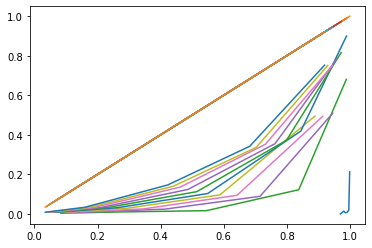

In [14]:
for plot in plots:
    plt.plot(plot[0], plot[1])
    plt.plot(plot[0], plot[0])
    
plt.show()

In [15]:
outputs_val = torch.stack([torch.sigmoid(output_val.squeeze()) for output_val in outputs_val], dim=1).detach().numpy().round(3)

In [16]:
# optimal cutoff point
cutoff = np.percentile(outputs_val[:, 5], 100 * (1-y_train.values.mean()))
cutoff

0.8119999766349792

In [17]:
preds = (outputs_val > cutoff)

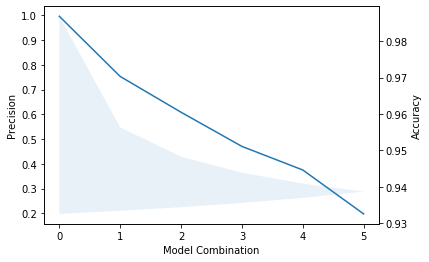

In [18]:
make_precision_accuracy_plot(outputs_val, preds, y_test)

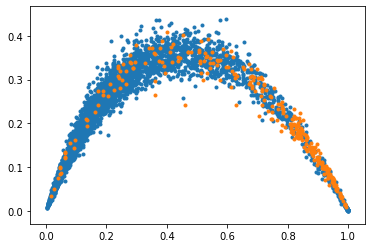

In [44]:
# uncertainties = np.var(outputs_val, axis=-1)
# uncertainties = outputs_val[:, 1] - outputs_val[:, 9]
uncertainties = outputs_val[:, 2] - outputs_val[:, 8]
# uncertainties = outputs_val[:, 3] - outputs_val[:, 7]
# uncertainties = outputs_val[:, 4] - outputs_val[:, 6]

preds_50 = preds[:, 5]
plt.scatter(outputs_val[:, 5][preds_50 == y_test.squeeze().values], uncertainties[preds_50 == y_test.squeeze().values], marker='.')
plt.scatter(outputs_val[:, 5][preds_50 != y_test.squeeze().values], uncertainties[preds_50 != y_test.squeeze().values], marker='.')


In [45]:
y_true = y_test.values.squeeze(-1)
y_prob = outputs_val[:, 5]
y_unc = uncertainties

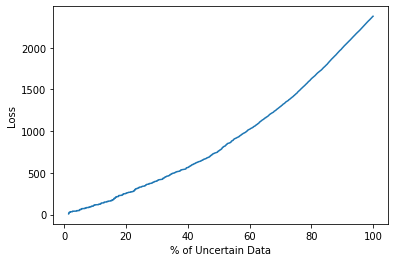

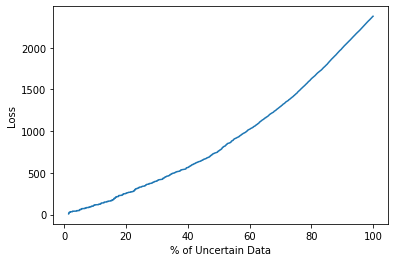

In [46]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'sum'})

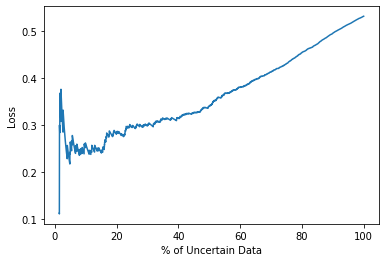

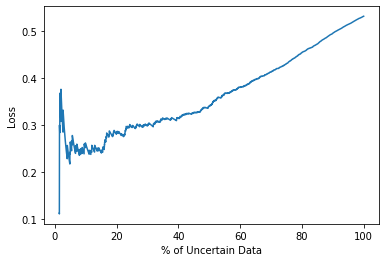

In [47]:
make_performance_uncertainty_plot(y_true, y_prob, y_unc, 'Loss', performance_fn_args={'reduction': 'mean'})

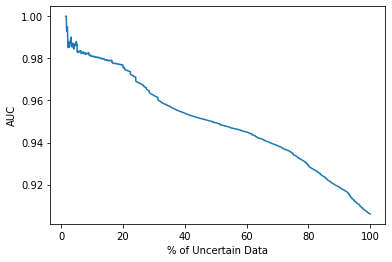

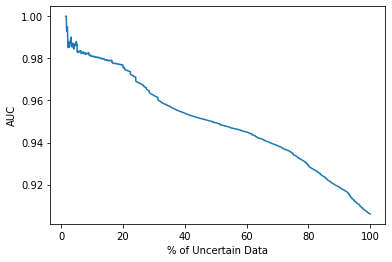

In [23]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [24]:
from utils import loss_at_50

In [25]:
loss_at_50(y_true, y_prob, uncertainties)

698.4511993519263

In [26]:
wrong_predictions = y_true != preds_50

In [27]:
roc_auc_score(wrong_predictions, uncertainties)


0.5529258040210969

In [28]:
average_precision_score(wrong_predictions, uncertainties)

0.07401401203714178

## Asymmetric entropy baseline

In [29]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


In [38]:
uncertainties = asymmetric_entropy(outputs_val[:, 5], cutoff)

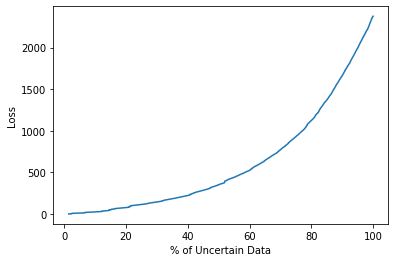

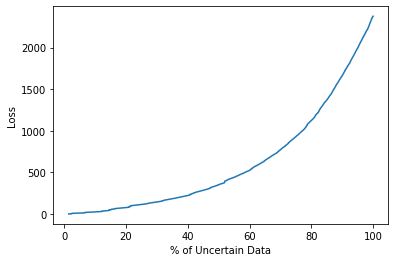

In [39]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

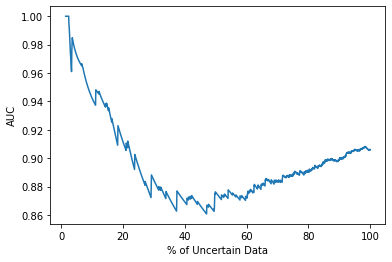

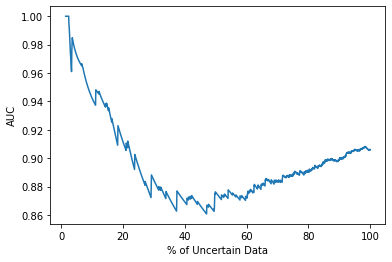

In [40]:
make_performance_uncertainty_plot(y_true, y_prob, uncertainties, 'AUC', performance_fn=roc_auc_score)

In [41]:
loss_at_50(y_true, y_prob, uncertainties)

351.8946208554553

In [42]:
roc_auc_score(wrong_predictions, uncertainties)

0.8549387318079074

In [43]:
average_precision_score(wrong_predictions, uncertainties)

0.33128259273616745